In [1]:
import argparse
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from eval import ToTensor, Normalize
from model import EventDetector
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd

In [2]:
event_names = {
    0: 'Address',
    1: 'Toe-up',
    2: 'Mid-backswing (arm parallel)',
    3: 'Top',
    4: 'Mid-downswing (arm parallel)',
    5: 'Impact',
    6: 'Mid-follow-through (shaft parallel)',
    7: 'Finish'
}


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [4]:
class SampleVideo(Dataset):
    def __init__(self, path, input_size=160, transform=None, filter_video_list = []):
        self.path = path
        self.input_size = input_size
        self.transform = transform

        # Get a list of all video files in the folder
        self.video_files = [os.path.join(path, f) for f in os.listdir(path) 
                            if f.endswith(('.mp4'))]
        if len(filter_video_list) > 0:
            filtered_list = [item for item in filter_video_list if item in self.video_files ]
            self.video_files = filtered_list


        # Check if the folder contains videos
        if not self.video_files:
            raise ValueError(f"No video files found in {path}.")

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        frame_size = [cap.get(cv2.CAP_PROP_FRAME_HEIGHT), cap.get(cv2.CAP_PROP_FRAME_WIDTH)]
        ratio = self.input_size / max(frame_size)
        new_size = tuple([int(x * ratio) for x in frame_size])
        delta_w = self.input_size - new_size[1]
        delta_h = self.input_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        # preprocess and return frames
        images = []
        for pos in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            _, img = cap.read()
            resized = cv2.resize(img, (new_size[1], new_size[0]))
            b_img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                       value=[0.406 * 255, 0.456 * 255, 0.485 * 255])  # ImageNet means (BGR)

            b_img_rgb = cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB)
            images.append(b_img_rgb)
        cap.release()
        labels = np.zeros(len(images)) # only for compatibility with transforms
        sample = {'images': np.asarray(images), 'labels': np.asarray(labels)}
        if self.transform:
            sample = self.transform(sample)
        return sample , video_path

In [5]:
# Define the folder containing videos
video_folder = "data/privatetest/kaggle_blurred/"

In [6]:
model = EventDetector(pretrain=True,
                    width_mult=1.,
                    lstm_layers=1,
                    lstm_hidden=256,
                    bidirectional=True,
                    dropout=False)
try:
    save_dict = torch.load('models/swingnet_1800.pth.tar')
except:
    print("Model weights not found. Download model weights and place in 'models' folder. See README for instructions")

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model.load_state_dict(save_dict['model_state_dict'])
model.to(device)
model.eval()
print("Loaded model weights")
seq_length = 64

Using device: cuda
Loaded model weights


In [8]:
def detect_events(dl):
    print('Identifying frames for each of the 8 events in the 1400 videos...')
    all_videos_frames =[]
    all_video_confidence = []
    video_paths = []
    ii = 0
    for sample,video_path in dl:
        print("Processing ", ii, ": ",  video_path[0])
        ii = ii + 1
        images = sample['images']
        video_paths.append(video_path[0])
        
        # full samples do not fit into GPU memory so evaluate sample in 'seq_length' batches
        batch = 0
        while batch * seq_length < images.shape[1]:
            if (batch + 1) * seq_length > images.shape[1]:
                image_batch = images[:, batch * seq_length:, :, :, :]
            else:
                image_batch = images[:, batch * seq_length:(batch + 1) * seq_length, :, :, :]
            logits = model(image_batch.cuda())
            if batch == 0:
                probs = F.softmax(logits.data, dim=1).cpu().numpy()
            else:
                probs = np.append(probs, F.softmax(logits.data, dim=1).cpu().numpy(), 0)
            batch += 1
    
        events = np.argmax(probs, axis=0)[:-1]
        #print('Predicted event frames: {}'.format(events))
        cap = cv2.VideoCapture(video_path[0])
        confidence = []
        for i, e in enumerate(events):
            confidence.append(probs[e, i])
        all_video_confidence.append(confidence)
        #print('Condifence: {}'.format([np.round(c, 3) for c in confidence]))
        
        img_list = [] 
        for i, e in enumerate(events):
            cap.set(cv2.CAP_PROP_POS_FRAMES, e)
            _, img = cap.read()
            #cv2.putText(img, '{:.3f}'.format(confidence[i]), (20, 20), cv2.FONT_HERSHEY_DUPLEX, 0.75, (0, 0, 255))
            #plt.imshow(img)
            #plt.show()
            img_list.append(img)
            #cv2.imshow(event_names[i], img)
            #cv2.waitKey(0)
            #cv2.destroyAllWindows()
        all_videos_frames.append(img_list)
    return all_videos_frames, video_paths

In [9]:
## Running it for whole images and save it in pickle file for quick reload if session dies
ds = SampleVideo(video_folder, transform=transforms.Compose([ToTensor(),
                                Normalize([0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]))
dl = DataLoader(ds, batch_size=1, shuffle=False, drop_last=False)
all_videos_frames, video_paths = detect_events(dl)
import pickle
with open('private_test_frame_estimate.pkl', 'wb') as handle:
    pickle.dump(all_videos_frames, handle)

Identifying frames for each of the 8 events in the 1400 videos...
Processing  0 :  data/privatetest/kaggle_blurred/blurred_Copy of CL - 2025 0205 112002 FLIR Blackfly S BFS-PGE-04S2C Down the line.mp4
Processing  1 :  data/privatetest/kaggle_blurred/blurred_Copy of DJ - 2024 1101 162837 FLIR Blackfly S BFS-PGE-04S2C Down the line.mp4
Processing  2 :  data/privatetest/kaggle_blurred/blurred_Copy of CB - 2025 0110 153658 FLIR Blackfly S BFS-PGE-04S2C Down the line.mp4
Processing  3 :  data/privatetest/kaggle_blurred/blurred_Copy of DJ- 2024 0927 163118 FLIR Blackfly S BFS-PGE-04S2C Down the line.mp4
Processing  4 :  data/privatetest/kaggle_blurred/blurred_Copy of IA - 2022 0914 123629 FLIR Blackfly S BFS-PGE-04S2C Down the line.mp4
Processing  5 :  data/privatetest/kaggle_blurred/blurred_Copy of CG - 2025 0113 112022 FLIR Blackfly S BFS-PGE-04S2C Down the line.mp4
Processing  6 :  data/privatetest/kaggle_blurred/blurred_Copy of BS - 2024 1106 171315 FLIR Blackfly S BFS-PGE-04S2C Down the

In [10]:
## lets check the predicted frames

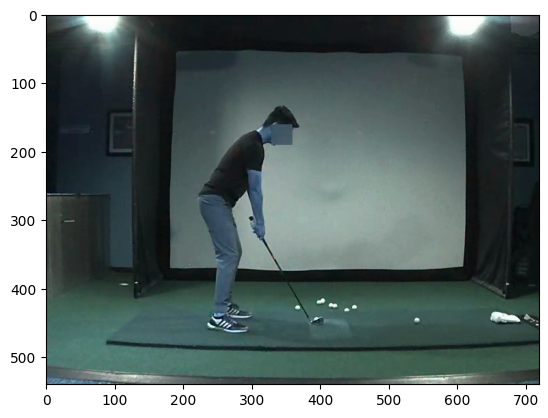

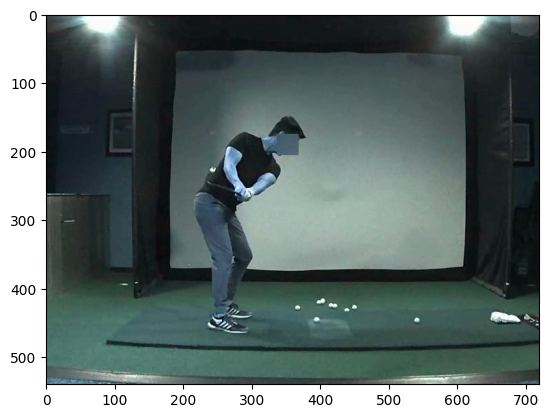

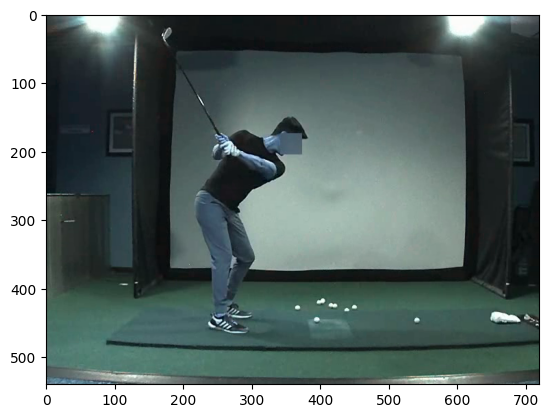

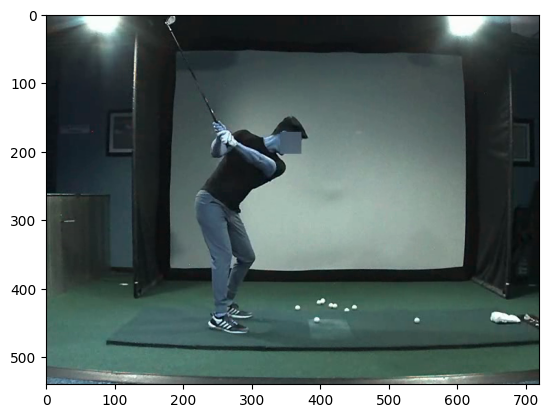

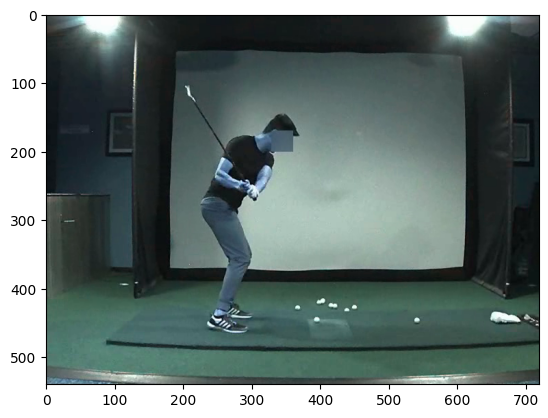

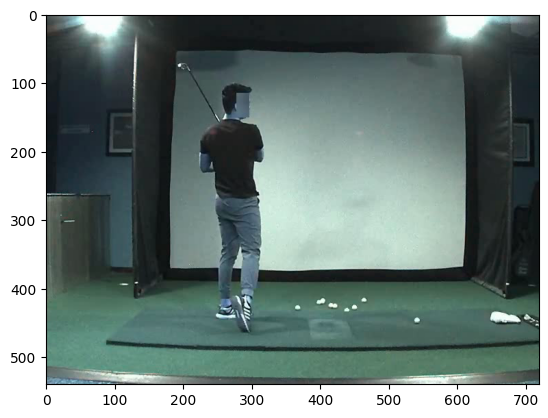

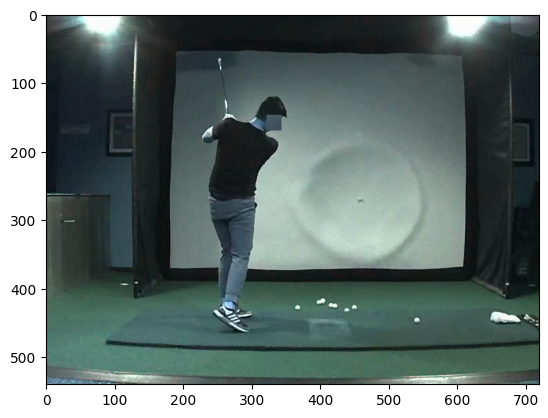

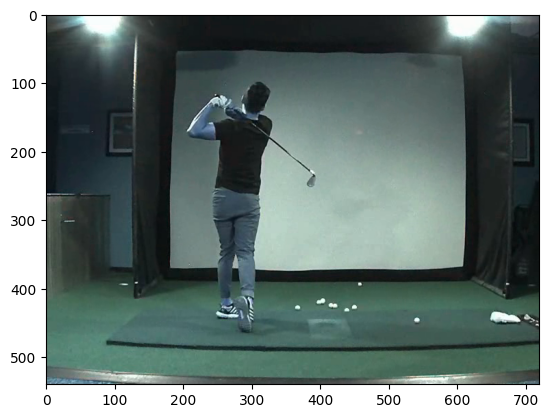

In [11]:
for frames in all_videos_frames:
    for frame in frames:
        plt.imshow(frame)
        plt.show()
    break

In [12]:
## lets run the pose estimation
from enum import IntEnum

class GetKeypoint(IntEnum):
    NOSE= 0
    LEFT_EYE = 1
    RIGHT_EYE = 2
    LEFT_EAR = 3
    RIGHT_EAR= 4
    LEFT_SHOULDER = 5
    RIGHT_SHOULDER = 6
    LEFT_ELBOW = 7
    RIGHT_ELBOW = 8
    LEFT_WRIST = 9
    RIGHT_WRIST = 10
    LEFT_HIP = 11
    RIGHT_HIP = 12
    LEFT_KNEE = 13
    RIGHT_KNEE = 14
    LEFT_ANKLE = 15
    RIGHT_ANKLE = 16

In [13]:
## do the pose estimation
# Load a model
pose_model = YOLO("yolo11x-pose.pt" )
results = [] 
for video_frames in all_videos_frames:
    results.append(pose_model(video_frames))


0: 480x640 1 person, 5.2ms
1: 480x640 1 person, 5.2ms
2: 480x640 1 person, 5.2ms
3: 480x640 1 person, 5.2ms
4: 480x640 1 person, 5.2ms
5: 480x640 1 person, 5.2ms
6: 480x640 1 person, 5.2ms
7: 480x640 1 person, 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4.9ms
1: 480x640 1 person, 4.9ms
2: 480x640 1 person, 4.9ms
3: 480x640 1 person, 4.9ms
4: 480x640 1 person, 4.9ms
5: 480x640 1 person, 4.9ms
6: 480x640 1 person, 4.9ms
7: 480x640 1 person, 4.9ms
Speed: 1.1ms preprocess, 4.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4.9ms
1: 480x640 1 person, 4.9ms
2: 480x640 1 person, 4.9ms
3: 480x640 1 person, 4.9ms
4: 480x640 1 person, 4.9ms
5: 480x640 1 person, 4.9ms
6: 480x640 1 person, 4.9ms
7: 480x640 1 person, 4.9ms
Speed: 0.8ms preprocess, 4.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4.7ms
1: 480x640 1 person, 4.7ms
2: 480

In [15]:
import pickle
with open('private_test_pose_estimate.pkl', 'wb') as handle:
    pickle.dump(results, handle)

In [14]:
# Define threshold for minimal head movement
THRESHOLD = 0.1  # Adjust based on your requirements

In [17]:
def calculate_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

In [18]:
def extract_head_position(pose_keypoints):
    """
    Extract head position from YOLOv11 pose keypoints.
    YOLOv11 pose keypoints format: [x1, y1, x2, y2, ..., x17, y17]
    Head is typically keypoint 0 (nose) or keypoint 1 (left eye).
    """
    if len(pose_keypoints) >= 2:  # Ensure keypoints are available
        return (pose_keypoints[0], pose_keypoints[1])  # Use nose as head position
    return None

In [19]:
def classify_stance(head_positions):
    """
    Classify stance as "good" or "bad" based on head movement.
    """
    address_pos = head_positions["Address"]
    top_pos = head_positions["Top"]
    impact_pos = head_positions["Impact"]

    distance_top = calculate_distance(address_pos, top_pos)
    distance_impact = calculate_distance(address_pos, impact_pos)
    if distance_top < THRESHOLD and distance_impact < THRESHOLD:
        return "Good", distance_top, distance_impact
    return "Bad", distance_top, distance_impact

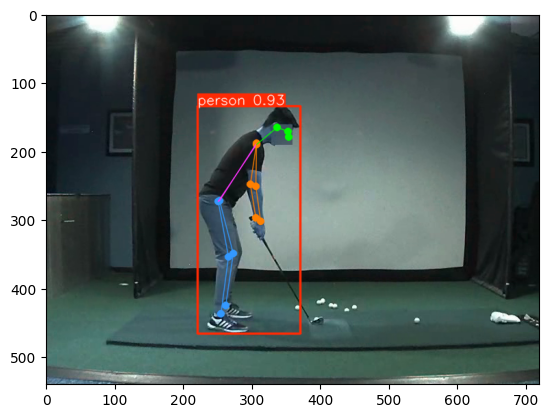

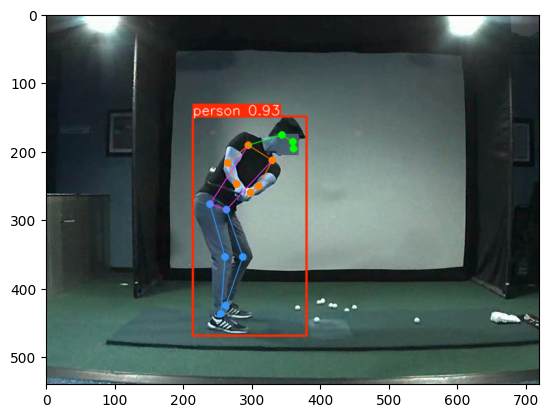

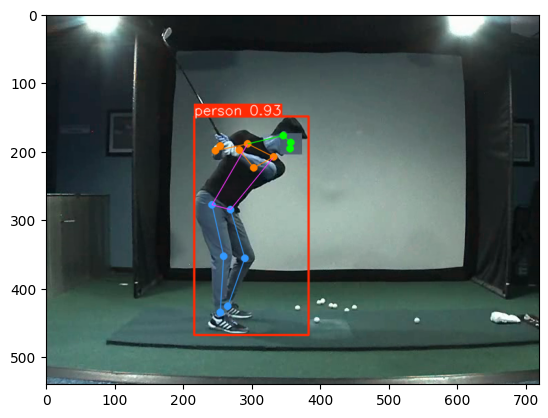

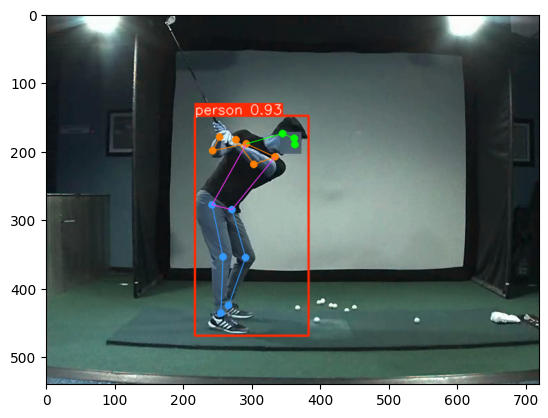

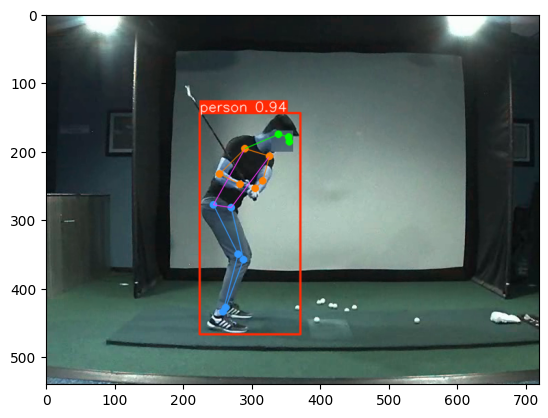

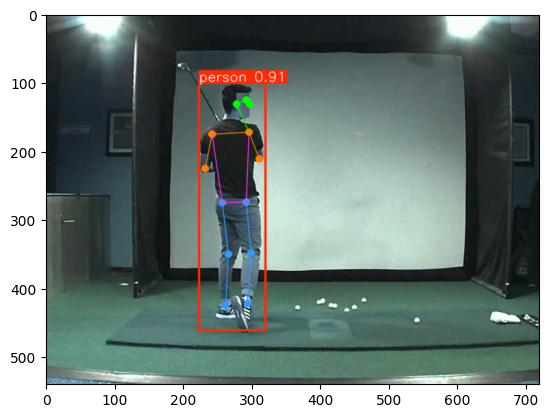

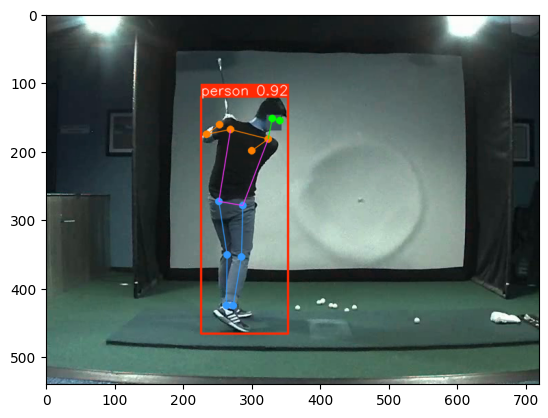

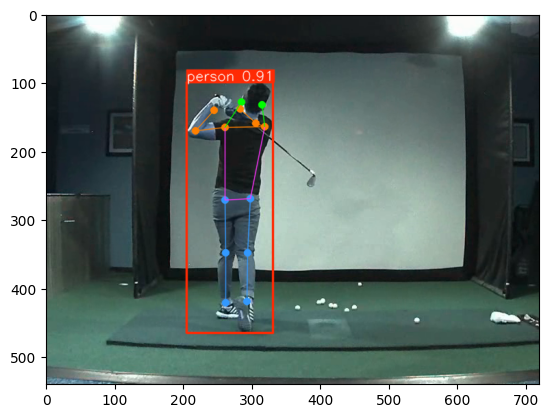

In [23]:
for result in results:
    for r in result:
        annotated_frame = r.plot()
        plt.imshow(annotated_frame)
        plt.show()
    break

In [37]:
def calculate_head_movement_metric(results, video_paths):
    ## lets first do the simple classification based on the head movement, using a threshold of 0.1, and only three events
    # Initialize head positions dictionary
    head_positions_list = []
    i = 0
    res_values = []
    for result in results:
        head_positions = {}
        for event_id in [0,3,5]:
            keypoints = result[event_id].keypoints.xyn.cpu().numpy()[0]
            head_position = extract_head_position(keypoints)
            head_positions[event_names[event_id]] = head_position 
        head_positions_list.append(head_positions)
        res, distance_top, distance_impact = classify_stance(head_positions)
        res_values.append({'video_path': video_paths[i], 'head movement': res,  'distance_top' : distance_top, 'distance_impact': distance_impact})

    res_df = pd.DataFrame(res_values)
    i = i + 1
    
    return res_df

In [39]:
head_movement_df = calculate_head_movement_metric(results,video_paths)

In [40]:
head_movement_df

,video_path,head movement,distance_top,distance_impact
0,data/privatetest/kaggle_blurred/blurred_Copy o...,Bad,0.023354,0.119307
1,data/privatetest/kaggle_blurred/blurred_Copy o...,Bad,0.723085,0.000000
2,data/privatetest/kaggle_blurred/blurred_Copy o...,Good,0.018052,0.004255
3,data/privatetest/kaggle_blurred/blurred_Copy o...,Bad,0.000000,0.627271
4,data/privatetest/kaggle_blurred/blurred_Copy o...,Bad,0.021071,0.592702
5,data/privatetest/kaggle_blurred/blurred_Copy o...,Good,0.003830,0.018700
6,data/privatetest/kaggle_blurred/blurred_Copy o...,Bad,0.571422,0.032422
7,data/privatetest/kaggle_blurred/blurred_Copy o...,Bad,0.009711,0.555439
8,data/privatetest/kaggle_blurred/blurred_Copy o...,Good,0.009121,0.014094
9,data/privatetest/kaggle_blurred/blurred_Copy o...,Good,0.022215,0.030400


In [41]:
def calculate_spine_angle(shoulder_left, shoulder_right, hip_left, hip_right):
    """
    Calculate the spine angle based on shoulder and hip keypoints.
    """
    shoulder_center = ((shoulder_left[0] + shoulder_right[0]) / 2, (shoulder_left[1] + shoulder_right[1]) / 2)
    hip_center = ((hip_left[0] + hip_right[0]) / 2, (hip_left[1] + hip_right[1]) / 2)
    
    # Calculate the angle between the vertical line and the spine
    delta_x = shoulder_center[0] - hip_center[0]
    delta_y = shoulder_center[1] - hip_center[1]
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    return angle

In [42]:
def calculate_center_hip(left_hip, right_hip):
    """
    Calculate the center hip keypoint as the midpoint between left and right hips.
    """
    center_hip = ((left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2)
    return center_hip

In [70]:
def analyze_weight_shift(hip_center, foot_left, foot_right):
    """
    Analyze weight shift based on hip and foot positions.
    """
    distance_left = abs(hip_center[0] - foot_left[0])
    distance_right = abs(hip_center[0] - foot_right[0])

    if distance_left > distance_right:        
        return "Weight on left foot", distance_left, distance_right
    else:        
        return "Weight on right foot",distance_left, distance_right

In [84]:
def calculate_knee_angle(hip, knee, ankle):
    """
    Calculate the knee angle based on hip, knee, and ankle keypoints.
    """
    a = np.array(hip)
    b = np.array(knee)
    c = np.array(ankle)
    
    ba = a - b
    bc = c - b

    # Check if either vector is a zero vector
    if np.linalg.norm(ba) == 0 or np.linalg.norm(bc) == 0:
        return np.nan  # Return NaN for invalid cases
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

    # Handle potential numerical issues (e.g., cosine_angle slightly outside [-1, 1])
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    
    angle = np.degrees(np.arccos(cosine_angle))
        
    return angle


In [85]:
def classify_stance_improved(head_positions, spine_angles, weight_shift, right_knee_angles, left_knee_angles):
    """
    Classify stance as "good" or "bad" using multiple features.
    """
    # Rule-based classification (can be replaced with a machine learning model)
    head_movement_good = all(calculate_distance(head_positions["Address"], pos) < THRESHOLD for pos in [head_positions["Top"], head_positions["Impact"]])
    spine_angle_good = all(abs(angle - spine_angles["Address"]) < 5 for angle in [spine_angles["Top"], spine_angles["Impact"]])
    weight_shift_good = weight_shift["Top"] == "Weight on right foot" and weight_shift["Impact"] == "Weight on left foot"
    right_knee_angle_good = all(160 <= angle <= 170 for angle in [right_knee_angles["Address"], right_knee_angles["Top"], right_knee_angles["Impact"]])
    left_knee_angle_good = all(150 <= angle <= 165 for angle in [left_knee_angles["Address"], left_knee_angles["Top"], left_knee_angles["Impact"]])

    return head_movement_good, spine_angle_good, weight_shift_good, right_knee_angle_good, left_knee_angle_good

In [86]:
# Initialize head positions dictionary
head_positions = {}
spine_angles = {}
weight_shifts = {}
left_knee_angles = {}
right_knee_angles = {}


i = 0
res_values = []
for result in results:
    for event_id in [0,3,5]:
        keypoints = result[event_id].keypoints.xyn.cpu().numpy()[0]
        head_position = extract_head_position(keypoints)
        shoulder_left_positions = keypoints[GetKeypoint.LEFT_SHOULDER.value]
        shoulder_right_positions = keypoints[GetKeypoint.RIGHT_SHOULDER.value]
        hip_left_positions = keypoints[GetKeypoint.LEFT_HIP.value]
        hip_right_positions = keypoints[GetKeypoint.RIGHT_HIP.value]
        knee_right_positions = keypoints[GetKeypoint.RIGHT_KNEE.value]
        knee_left_positions = keypoints[GetKeypoint.LEFT_KNEE.value]
        ankle_left_positions = keypoints[GetKeypoint.LEFT_ANKLE.value]
        ankle_right_positions = keypoints[GetKeypoint.RIGHT_ANKLE.value]
        
        hip_center_positions = calculate_center_hip(hip_left_positions,hip_right_positions)
        foot_left_positions = ankle_left_positions
        foot_right_positions = ankle_right_positions
    
        # Calculate spine angle
        spine_angle = calculate_spine_angle(shoulder_left_positions, shoulder_right_positions, hip_left_positions, hip_right_positions)
        # Analyze weight shift
        weight_shift = analyze_weight_shift(hip_center_positions, foot_left_positions, foot_right_positions)
        # Calculate knee angles
        left_knee_angle = calculate_knee_angle(hip_left_positions, knee_left_positions, ankle_left_positions)
        right_knee_angle = calculate_knee_angle(hip_right_positions, knee_right_positions, ankle_right_positions)

        head_positions[event_names[event_id]] = head_position
        spine_angles[event_names[event_id]] = spine_angle  
        weight_shifts[event_names[event_id]] = weight_shift
        left_knee_angles[event_names[event_id]] = left_knee_angle
        right_knee_angles[event_names[event_id]] = right_knee_angle
    head_movement_good, spine_angle_good, weight_shift_good, right_knee_angle_good, left_knee_angle_good = classify_stance_improved(head_positions, spine_angles, weight_shifts, right_knee_angles, left_knee_angles)
    res_values.append({'video_path': video_paths[i], 'head movement': head_movement_good, 'spine angle' : spine_angle_good, 'weight shift': weight_shift_good, 'right knee angle' : right_knee_angle_good, 'left knee angle': left_knee_angle_good})
    i = i + 1

In [87]:
df = pd.DataFrame(res_values)

In [88]:
df

,video_path,head movement,spine angle,weight shift,right knee angle,left knee angle
0,data/privatetest/kaggle_blurred/blurred_Copy o...,False,False,False,False,False
1,data/privatetest/kaggle_blurred/blurred_Copy o...,False,False,False,False,False
2,data/privatetest/kaggle_blurred/blurred_Copy o...,True,False,False,False,True
3,data/privatetest/kaggle_blurred/blurred_Copy o...,False,False,False,False,False
4,data/privatetest/kaggle_blurred/blurred_Copy o...,False,False,False,False,False
5,data/privatetest/kaggle_blurred/blurred_Copy o...,True,True,False,False,True
6,data/privatetest/kaggle_blurred/blurred_Copy o...,False,True,False,False,False
7,data/privatetest/kaggle_blurred/blurred_Copy o...,False,False,False,False,False
8,data/privatetest/kaggle_blurred/blurred_Copy o...,True,True,False,False,True
9,data/privatetest/kaggle_blurred/blurred_Copy o...,True,True,False,False,False
